In [ ]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow.keras as keras
import keras.backend as K
import tensorflow.keras.layers as L
from glob import glob
from PIL import Image
import imghdr
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D, Concatenate, Conv2DTranspose, GlobalAveragePooling2D, BatchNormalization, ReLU, Reshape, Resizing, Add, SeparableConv2D, MultiHeadAttention, UpSampling2D, LayerNormalization, ZeroPadding2D, DepthwiseConv2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

2024-06-04 03:10:53.376680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 03:10:53.376779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 03:10:53.514879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 10015 files belonging to 7 classes.
Batch classes:  [5 5 2 5 5 2 5 4 5 5 5 5 0 5 4 5 5 5 5 0 2 5 4 5 5 5 1 5 5 5 4 5]


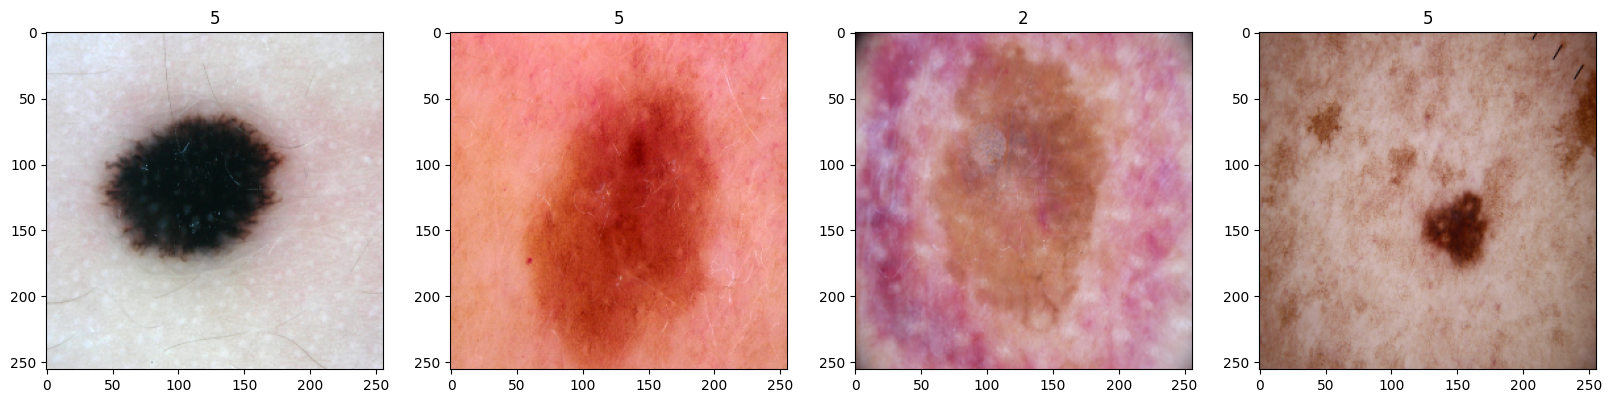

In [ ]:
#@title Creating Data Pipeline
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/ham10000/HAM10000_images', shuffle=True)

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print("Batch classes: ", batch[1])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
# Access class names
class_names = data.class_names

# Print class names and their corresponding labels
for label, class_name in enumerate(class_names):
    print(f"Label {label}: {class_name}")

Label 0: akiec
Label 1: bcc
Label 2: bkl
Label 3: df
Label 4: mel
Label 5: nv
Label 6: vasc


In [ ]:
#@title Preprocessing Data

''' Scaling Data '''
# Scaling Data
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()[0].max()


''' Splitting Data '''
train_size = int(len(data)*.7)
val_size = int(len(data)*.1)+1
test_size = int(len(data)*.2)+1

train = data.take(train_size)
val = data.take(val_size)
test = data.take(test_size)

print(train_size, "+", test_size, "+", val_size, "=", len(data))

219 + 63 + 32 = 313


In [ ]:
#@title Assigning weights to classes
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

labels = []
for batch in tqdm(train.as_numpy_iterator()):
    X1, y1 = batch
    labels.extend(list(y1))

labels = np.array(labels)
print(labels)

# Calculate class weights using scikit-learn's compute_class_weight function
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(labels), y = labels)
class_weights = dict(zip(np.unique(labels), class_weights))

219it [00:24,  9.07it/s]

[0 5 5 ... 2 2 5]


# **Deep Learning Models Creation, Training, Evaluating, Saving, Performance Graph etc.**

In [ ]:
class EarthMoversDistanceLayer(tf.keras.layers.Layer):
    def __init__(self, prune_lim=2, mode="mean", trim=False, **kwargs):
        super(EarthMoversDistanceLayer, self).__init__(**kwargs)
        self.prune_lim = prune_lim
        self.mode = mode
        self.trim = trim

    def cdf_scores(self, central, vectors):
        cucentral = tf.math.cumsum(central, axis=-1)
        cuvector = tf.math.cumsum(vectors, axis=-1)

        diff = cuvector - cucentral
        emd_scores = tf.expand_dims(tf.math.reduce_sum(tf.math.abs(diff), axis=-1), axis=-1)

        return emd_scores

    def emd_func(self, central, stacked_output, *argv):
        L = len(argv)
        arg_shape = argv[0].shape

        similarities = self.cdf_scores(central, stacked_output)
        similarities = similarities * (-1)

        Xmax = tf.expand_dims(tf.reduce_max(similarities, axis=None), axis=-1)
        Xmin = tf.expand_dims(tf.reduce_min(similarities, axis=None), axis=-1)
        condition = Xmax[0] == Xmin[0]
        Xmin = tf.expand_dims(tf.where(condition, (Xmin[0]-0.000001), Xmin[0]), axis=-1)
        Ymax = tf.fill(tf.shape(Xmax), 1.0); Ymin = tf.fill(tf.shape(Xmin), 0.5)
        MV = (((similarities - Xmin) * (Ymax - Ymin))/(Xmax - Xmin)) + Ymin

        features=[]
        for i, arg in enumerate(argv):
            x = MV[:, i, :]
            x = tf.tile(x, [1, arg.shape[-3]])
            x = tf.expand_dims(x, axis=-1)
            x = tf.tile(x, [1, 1, arg.shape[-2]])
            x = tf.expand_dims(x, axis=-1)
            temp = arg*x
            features.append(temp)

        result = tf.stack(features, axis=-1)
        result = result[:, :, :, 0, :]
        return result

    def call(self, inputs):
        l = []; atten_scores=None;
        for i in range(inputs.shape[-1]):
            l.append(tf.expand_dims(inputs[:, :, :, i], axis=-1))

        flattened_outp = [tf.reshape(i, [-1, tf.shape(i)[1] * tf.shape(i)[2] * tf.shape(i)[3]]) for i in l]
        stacked_outp = tf.stack(flattened_outp, axis=1)

        if self.mode == "mean":
            mean = tf.reduce_mean(inputs, axis=-1, keepdims=True)
            mean = tf.reshape(mean, [-1, tf.shape(mean)[1] * tf.shape(mean)[2] * tf.shape(mean)[3]])
            mean = [mean for i in l]
            mean = tf.stack(mean, axis=1)
            atten_scores = self.emd_func(mean, stacked_outp, *l)
        elif self.mode == "median":
            median = tf.keras.ops.median(inputs, axis=-1, keepdims=True)
            median = tf.reshape(median, [-1, tf.shape(median)[1] * tf.shape(median)[2] * tf.shape(median)[3]])
            median = [median for i in l]
            median = tf.stack(median, axis=1)
            atten_scores = self.emd_func(median, stacked_outp, *l)
        return atten_scores

In [ ]:
#@title MobileNetV2

def mod(img_shape, n_classes):
    input_x = Input(shape=img_shape, name='input_1')

    # Conv1 block
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', use_bias=False, name='Conv1')(input_x)
    x = BatchNormalization(name='bn_Conv1')(x)
    x = ReLU(name='Conv1_relu')(x)

    # Expanded Conv block
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='expanded_conv_depthwise')(x)
    x = BatchNormalization(name='expanded_conv_depthwise_BN')(x)
    x = ReLU(name='expanded_conv_depthwise_relu')(x)
    x = Conv2D(16, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='expanded_conv_project')(x)
    x = BatchNormalization(name='expanded_conv_project_BN')(x)

    # block_1
    x = Conv2D(96, (1, 1), strides=(1, 1), padding='same', name='block_1_expand')(x)
    x = BatchNormalization(name='block_1_expand_BN')(x)
    x = ReLU(name='block_1_expand_relu')(x)
    x = ZeroPadding2D(padding=((1, 0), (1, 0)), name='block_1_pad')(x)
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding='valid', use_bias=False, name='block_1_depthwise')(x)
    x = BatchNormalization(name='block_1_depthwise_BN')(x)
    x = ReLU(name='block_1_depthwise_relu')(x)
    x = Conv2D(24, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_1_project')(x)
    x_1 = BatchNormalization(name='block_1_project_BN')(x)

    # block_2
    x = Conv2D(144, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_2_expand')(x_1)
    x = BatchNormalization(name='block_2_expand_BN')(x)
    x = ReLU(name='block_2_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_2_depthwise')(x)
    x = BatchNormalization(name='block_2_depthwise_BN')(x)
    x = ReLU(name='block_2_depthwise_relu')(x)
    x = Conv2D(24, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_2_project')(x)
    x = BatchNormalization(name='block_2_project_BN')(x)
    x = Add(name='block_2_add')([x_1, x])
    x = EarthMoversDistanceLayer(mode="median", name="median_emd")(x)

    # block_3
    x = Conv2D(144, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_3_expand')(x)
    x = BatchNormalization(name='block_3_expand_BN')(x)
    x = ReLU(name='block_3_expand_relu')(x)
    x = ZeroPadding2D(padding=((1, 0), (1, 0)), name='block_3_pad')(x)
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding='valid', use_bias=False, name='block_3_depthwise')(x)
    x = BatchNormalization(name='block_3_depthwise_BN')(x)
    x = ReLU(name='block_3_depthwise_relu')(x)
    x = Conv2D(32, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_3_project')(x)
    x_3 = BatchNormalization(name='block_3_project_BN')(x)

    # block_4
    x = Conv2D(192, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_4_expand')(x_3)
    x = BatchNormalization(name='block_4_expand_BN')(x)
    x = ReLU(name='block_4_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_4_depthwise')(x)
    x = BatchNormalization(name='block_4_depthwise_BN')(x)
    x = ReLU(name='block_4_depthwise_relu')(x)
    x = Conv2D(32, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_4_project')(x)
    x = BatchNormalization(name='block_4_project_BN')(x)
    x_4 = Add(name='block_4_add')([x_3, x])

    # block_5
    x = Conv2D(192, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_5_expand')(x_4)
    x = BatchNormalization(name='block_5_expand_BN')(x)
    x = ReLU(name='block_5_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_5_depthwise')(x)
    x = BatchNormalization(name='block_5_depthwise_BN')(x)
    x = ReLU(name='block_5_depthwise_relu')(x)
    x = Conv2D(32, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_5_project')(x)
    x = BatchNormalization(name='block_5_project_BN')(x)
    x = Add(name='block_5_add')([x_4, x])

    # block_6
    x = Conv2D(192, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_6_expand')(x)
    x = BatchNormalization(name='block_6_expand_BN')(x)
    x = ReLU(name='block_6_expand_relu')(x)
    x = ZeroPadding2D(padding=((1, 0), (1, 0)), name='block_6_pad')(x)
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding='valid', use_bias=False, name='block_6_depthwise')(x)
    x = BatchNormalization(name='block_6_depthwise_BN')(x)
    x = ReLU(name='block_6_depthwise_relu')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_6_project')(x)
    x_6 = BatchNormalization(name='block_6_project_BN')(x)

    # block_7
    x = Conv2D(384, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_7_expand')(x_6)
    x = BatchNormalization(name='block_7_expand_BN')(x)
    x = ReLU(name='block_7_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_7_depthwise')(x)
    x = BatchNormalization(name='block_7_depthwise_BN')(x)
    x = ReLU(name='block_7_depthwise_relu')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_7_project')(x)
    x = BatchNormalization(name='block_7_project_BN')(x)
    x_7 = Add(name='block_7_add')([x_6, x])

    # block_8
    x = Conv2D(384, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_8_expand')(x_7)
    x = BatchNormalization(name='block_8_expand_BN')(x)
    x = ReLU(name='block_8_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_8_depthwise')(x)
    x = BatchNormalization(name='block_8_depthwise_BN')(x)
    x = ReLU(name='block_8_depthwise_relu')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_8_project')(x)
    x = BatchNormalization(name='block_8_project_BN')(x)
    x_8 = Add(name='block_8_add')([x_7, x])

    # block_9
    x = Conv2D(384, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_9_expand')(x_8)
    x = BatchNormalization(name='block_9_expand_BN')(x)
    x = ReLU(name='block_9_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_9_depthwise')(x)
    x = BatchNormalization(name='block_9_depthwise_BN')(x)
    x = ReLU(name='block_9_depthwise_relu')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_9_project')(x)
    x = BatchNormalization(name='block_9_project_BN')(x)
    x = Add(name='block_9_add')([x_8, x])

    # block_10
    x = Conv2D(384, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_10_expand')(x)
    x = BatchNormalization(name='block_10_expand_BN')(x)
    x = ReLU(name='block_10_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', use_bias=False, name='block_10_depthwise')(x)
    x = BatchNormalization(name='block_10_depthwise_BN')(x)
    x = ReLU(name='block_10_depthwise_relu')(x)
    x = Conv2D(96, (1, 1), strides=(1, 1), padding='same', use_bias=False, name='block_10_project')(x)
    x_10 = BatchNormalization(name='block_10_project_BN')(x)

    # block_11
    x = Conv2D(576, (1, 1), padding='same', use_bias=False, name='block_11_expand')(x_10)
    x = BatchNormalization(name='block_11_expand_BN')(x)
    x = ReLU(name='block_11_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), padding='same', use_bias=False, name='block_11_depthwise')(x)
    x = BatchNormalization(name='block_11_depthwise_BN')(x)
    x = ReLU(name='block_11_depthwise_relu')(x)
    x = Conv2D(96, (1, 1), padding='same', use_bias=False, name='block_11_project')(x)
    x = BatchNormalization(name='block_11_project_BN')(x)
    x_11 = Add(name='block_11_add')([x_10, x])

    # block_12
    x = Conv2D(576, (1, 1), padding='same', use_bias=False, name='block_12_expand')(x_11)
    x = BatchNormalization(name='block_12_expand_BN')(x)
    x = ReLU(name='block_12_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), padding='same', use_bias=False, name='block_12_depthwise')(x)
    x = BatchNormalization(name='block_12_depthwise_BN')(x)
    x = ReLU(name='block_12_depthwise_relu')(x)
    x = Conv2D(96, (1, 1), padding='same', use_bias=False, name='block_12_project')(x)
    x = BatchNormalization(name='block_12_project_BN')(x)
    x = Add(name='block_12_add')([x_11, x])

    # block_13
    x = Conv2D(576, (1, 1), padding='same', use_bias=False, name='block_13_expand')(x)
    x = BatchNormalization(name='block_13_expand_BN')(x)
    x = ReLU(name='block_13_expand_relu')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='block_13_pad')(x)
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding='valid', use_bias=False, name='block_13_depthwise')(x)
    x = BatchNormalization(name='block_13_depthwise_BN')(x)
    x = ReLU(name='block_13_depthwise_relu')(x)
    x = Conv2D(160, (1, 1), padding='same', use_bias=False, name='block_13_project')(x)
    x_13 = BatchNormalization(name='block_13_project_BN')(x)
    x_13 = EarthMoversDistanceLayer(mode="mean", name="mean_emd")(x_13)

    # block_14
    x = Conv2D(960, (1, 1), padding='same', use_bias=False, name='block_14_expand')(x_13)
    x = BatchNormalization(name='block_14_expand_BN')(x)
    x = ReLU(name='block_14_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), padding='same', use_bias=False, name='block_14_depthwise')(x)
    x = BatchNormalization(name='block_14_depthwise_BN')(x)
    x = ReLU(name='block_14_depthwise_relu')(x)
    x = Conv2D(160, (1, 1), padding='same', use_bias=False, name='block_14_project')(x)
    x = BatchNormalization(name='block_14_project_BN')(x)
    x_14 = Add(name='block_14_add')([x_13, x])

    # block_15
    x = Conv2D(960, (1, 1), padding='same', use_bias=False, name='block_15_expand')(x_14)
    x = BatchNormalization(name='block_15_expand_BN')(x)
    x = ReLU(name='block_15_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), padding='same', use_bias=False, name='block_15_depthwise')(x)
    x = BatchNormalization(name='block_15_depthwise_BN')(x)
    x = ReLU(name='block_15_depthwise_relu')(x)
    x = Conv2D(160, (1, 1), padding='same', use_bias=False, name='block_15_project')(x)
    x = BatchNormalization(name='block_15_project_BN')(x)
    x = Add(name='block_15_add')([x_14, x])

    # block_16
    x = Conv2D(960, (1, 1), padding='same', use_bias=False, name='block_16_expand')(x)
    x = BatchNormalization(name='block_16_expand_BN')(x)
    x = ReLU(name='block_16_expand_relu')(x)
    x = DepthwiseConv2D((3, 3), padding='same', use_bias=False, name='block_16_depthwise')(x)
    x = BatchNormalization(name='block_16_depthwise_BN')(x)
    x = ReLU(name='block_16_depthwise_relu')(x)
    x = Conv2D(320, (1, 1), padding='same', use_bias=False, name='block_16_project')(x)
    x = BatchNormalization(name='block_16_project_BN')(x)

    # Final
    x = Conv2D(1280, (1, 1), padding='same', use_bias=False, name='Conv_1')(x)
    x = BatchNormalization(name='Conv_1_bn')(x)
    x = ReLU(name='out_relu')(x)

    # Final Layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate = 0.2)(x)

    x = Dense(256, activation='relu')(x)
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=input_x, outputs=output, name="MobileNetV2EMD")
    return model

input_shape = (256, 256, 3)
n_classes = 7

model = mod(input_shape, n_classes)
model.compile('Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "MobileNetV2EMD"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,632 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,587,815 (9.87 MB)

 Trainable params: 2,553,703 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
#@title Training the Models

# Train
logdir='/kaggle/working/logs'
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir)

tensorboard_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/mobilenet.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
    )

hist = model.fit(train, class_weight=class_weights, epochs=200, validation_data=val, callbacks=[tensorboard_callback1, tensorboard_callback2])
print(hist.history)

Epoch 1/200


I0000 00:00:1717470827.420958     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717470827.547563     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.2106 - loss: 2.0948

W0000 00:00:1717470939.712402     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.05859, saving model to /kaggle/working/mobilenet.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 243s 553ms/step - accuracy: 0.2105 - loss: 2.0942 - val_accuracy: 0.0586 - val_loss: 2.0834
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3267 - loss: 1.6436
Epoch 2: val_accuracy did not improve from 0.05859
219/219 ━━━━━━━━━━━━━━━━━━━━ 106s 483ms/step - accuracy: 0.3268 - loss: 1.6436 - val_accuracy: 0.0078 - val_loss: 1.9765
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.3203 - loss: 1.5905
Epoch 3: val_accuracy improved from 0.05859 to 0.47559, saving model to /kaggle/working/mobilenet.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 106s 483ms/step - accuracy: 0.3203 - loss: 1.5904 - val_accuracy: 0.4756 - val_loss: 1.3156
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.3751 - loss: 1.4790
Epoch 4: val_accuracy did not improve from 0.47559
219/219 ━━━━━━━━━━━━━━━━━━━━ 105s 481ms/step - accur

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - accuracy: 0.9919 - loss: 0.0236
Result : 
 0.9910714030265808
Loss: 
 0.023883584886789322
For MobileNetV2: 


W0000 00:00:1717492043.825592     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Precision:1.0, Recall:0.9994853138923645, Accuracy (Binary):0.0863095223903656, Accuracy (sparse_categorical):[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
For Test Dataset: 
Precision:1.0, Recall:0.9994853138923645, Accuracy (Binary):0.0863095223903656
Confusion Matrix for Xception on Test Dataset: 
 [[  73    0    0    0    0    0    0]
 [   0  101    0    0    0    0    0]
 [   0    0  220    0    0    3    0]
 [   0    0    0   17    0    0    0]
 [   0    0    0    0  237    1    0]
 [   1    0    8    0    4 1318    1]
 [   0    0    0    0    0    0   32]]


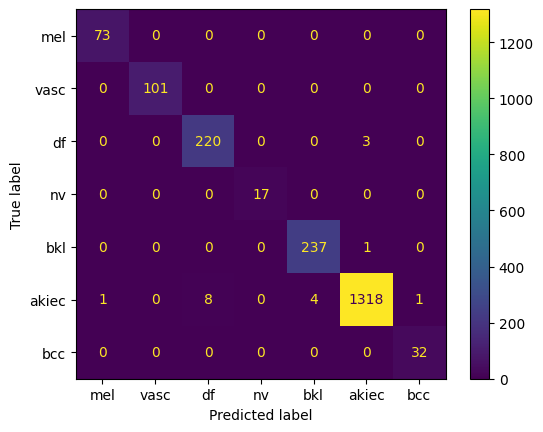

In [ ]:
#@title Evaluating the Models

''' Evaluation '''
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, sparse_categorical_accuracy
from sklearn.metrics import *

model.load_weights("/kaggle/working/mobilenet.weights.h5")
loss, results = model.evaluate(test, batch_size=328, callbacks=[tensorboard_callback1, tensorboard_callback2])
print("Result : \n", results)
print("Loss: \n", loss)

''' MobileNetV2 '''
print("For MobileNetV2: ")
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
labels = []
predicts = []
pre3 = Precision()
re3 = Recall()
acc3 = BinaryAccuracy()
for batch3 in test.as_numpy_iterator():
    X3, y3 = batch3
    labels.extend(list(y3))
    yhat3 = model.predict(X3, verbose=0)
    max = a = 0
    arr = np.ones(yhat3.shape[0])*-1
    for i in yhat3:
        max = np.argmax(i)
        arr[a] = max
        a+=1
    predicts.extend(list(arr))
    pre3.update_state(y3, arr)
    re3.update_state(y3, arr)
    acc3.update_state(y3, arr)
acc31 = sparse_categorical_accuracy(y3, yhat3)
assert acc31.shape == (y3.shape[0],)
print(f'Precision:{pre3.result().numpy()}, Recall:{re3.result().numpy()}, Accuracy (Binary):{acc3.result().numpy()}, Accuracy (sparse_categorical):{acc31.numpy()}')

print("For Test Dataset: ")
pre.update_state(labels, predicts)
re.update_state(labels, predicts)
acc.update_state(labels, predicts)
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy (Binary):{acc.result().numpy()}')
matrix = confusion_matrix(labels, predicts)
print("Confusion Matrix for Xception on Test Dataset: \n", matrix)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = os.listdir("/kaggle/input/ham10000/HAM10000_images"))
display.plot()
plt.show()

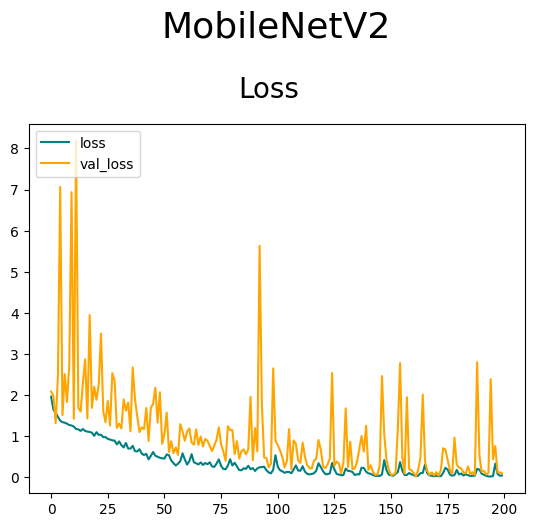

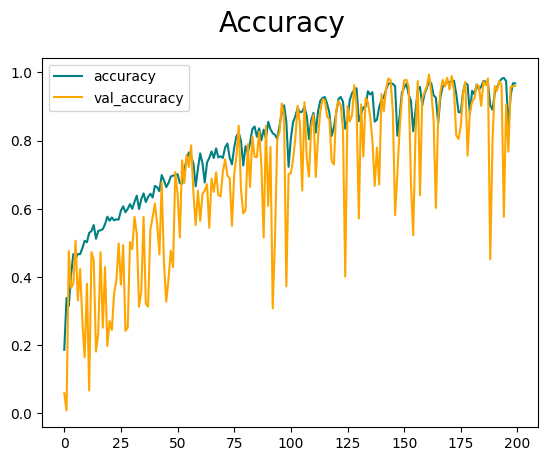

In [ ]:
#@title Performance Graphs

import matplotlib.pyplot as plt

''' Model 1 '''
# Loss
fig = plt.figure()
plt.title("MobileNetV2\n\n", loc='center', fontsize=26)
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
#@title ROC-AUC Curves

import pandas as pd
import numpy as np
from sklearn.metrics import *
import math, os
from sklearn.preprocessing import label_binarize

#ROC-AUC
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
def plot_roc(val_label,decision_val, caption='ROC Curve'):
    num_classes=np.unique(val_label).shape[0]
    classes = []
    for i in range(num_classes):
        classes.append(i)
    plt.figure()
    decision_val = label_binarize(decision_val, classes=classes)

    if num_classes!=2:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            y_val = label_binarize(val_label, classes=classes)
            fpr[i], tpr[i], _ = roc_curve(y_val[:, i], decision_val[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(i+1, roc_auc[i]))
    else:
        fpr,tpr,_ = roc_curve(val_label,decision_val, pos_label=1)
        roc_auc = auc(fpr,tpr)*100
        plt.plot(fpr,tpr,label='ROC curve (AUC=%0.2f)'%roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)
    plt.legend(loc="lower right",  bbox_to_anchor=(1, 0.5))
    plt.savefig(str(len(classes))+'.png',dpi=300)

def predicting(ensemble_prob):
    prediction = np.zeros((ensemble_prob.shape[0],))
    for i in range(ensemble_prob.shape[0]):
        temp = ensemble_prob[i]
        t = np.where(temp == np.max(temp))[0][0]
        prediction[i] = t
    return prediction

def metrics(labels, predictions, classes, display_label):
    print("Classification Report:")
    print("Labels : ",labels.shape, '\nPredictions : ', predictions.shape)
    print(classification_report(labels, predictions, target_names = classes, digits = 4))
    matrix = confusion_matrix(labels, predictions)
    print("Confusion matrix:")
    print(matrix)
    plt.figure()
    display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = display_label)
    display.plot()
    plt.xticks(rotation=50)
    plt.show()
    print("\nClasswise Accuracy :{}".format(matrix.diagonal()/matrix.sum(axis = 1)))
    print("\nBalanced Accuracy Score: ",balanced_accuracy_score(labels,predictions))

For Xception : 
Classification Report:
Labels :  (2016,) 
Predictions :  (2016,)
              precision    recall  f1-score   support

           1     0.9737    1.0000    0.9867        74
           2     1.0000    1.0000    1.0000       101
           3     0.9680    0.9907    0.9792       214
           4     1.0000    1.0000    1.0000        18
           5     0.9831    0.9957    0.9893       233
           6     0.9977    0.9896    0.9936      1342
           7     0.9714    1.0000    0.9855        34

    accuracy                         0.9916      2016
   macro avg     0.9848    0.9966    0.9906      2016
weighted avg     0.9917    0.9916    0.9916      2016

Confusion matrix:
[[  74    0    0    0    0    0    0]
 [   0  101    0    0    0    0    0]
 [   0    0  212    0    0    2    0]
 [   0    0    0   18    0    0    0]
 [   0    0    0    0  232    1    0]
 [   2    0    7    0    4 1328    1]
 [   0    0    0    0    0    0   34]]


<Figure size 640x480 with 0 Axes>

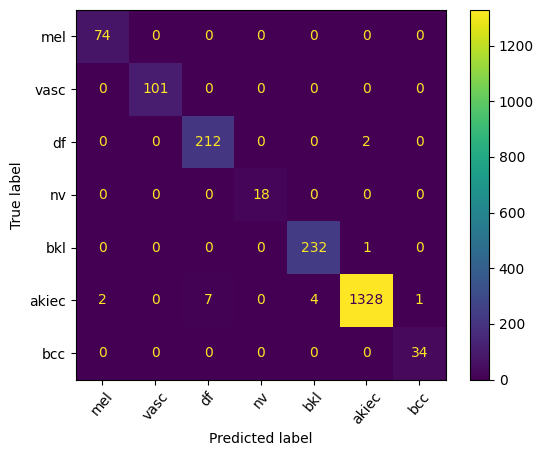


Classwise Accuracy :[1.         1.         0.99065421 1.         0.99570815 0.98956781
 1.        ]

Balanced Accuracy Score:  0.9965614527648363
Accuracy[0.9916] Precision[0.9848] Recall[0.9966] F1[0.9906] ]
________________________________________________________________


Overall Accuracy[0.9916] Overall Precision[0.9848] Overall Recall[0.9966] Overall F1[0.9906]


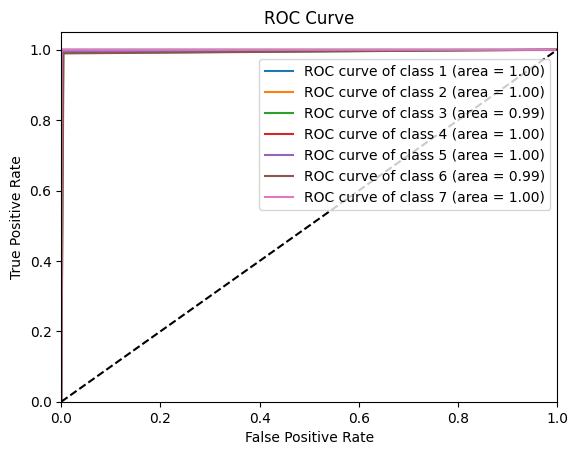

In [ ]:
#@title Precision, Recall and Accuracy of the Models with respect to test dataset

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

labels = []
p1 = []
p11 = []
for batch1 in test.as_numpy_iterator():
    X1, y1 = batch1
    labels.extend(list(y1))
    yhat1 = model.predict(X1, verbose=0)
    max = 0
    for i in yhat1:
        max = np.argmax(i)
        p1.append(max)
        p11.append(i)

labels = np.asarray(labels)
p1 = np.asarray(p1)

import csv
fp = open("/kaggle/working/mobilenetv2.csv",'w+',newline = '')
writer = csv.writer(fp)
for i in p11:
    l = [i[j] for j in range(7)]
    writer.writerow(l)
fp.close()

fp = open("/kaggle/working/labels.csv",'w+',newline = '')
writer = csv.writer(fp)
for i in labels:
    writer.writerow([i])
fp.close()


print("For MobileNetV2 : ")
metrics(labels, p1,  list(map(str, range(1, 8))), os.listdir("/kaggle/input/ham10000/HAM10000_images"))
plot_roc(labels, p1)

avg_acc_list = []
avg_precision_list = []
avg_recall_list = []
avg_f1_list = []

acc_fold = accuracy_score(labels, p1)
avg_acc_list.append(acc_fold)
precision_fold = precision_score(labels, p1, average='macro')
avg_precision_list.append(precision_fold)
recall_fold = recall_score(labels, p1, average='macro')
avg_recall_list.append(recall_fold)
f1_fold  = f1_score(labels, p1, average='macro')
avg_f1_list.append(f1_fold)

print('Accuracy[{:.4f}] Precision[{:.4f}] Recall[{:.4f}] F1[{:.4f}] ]'.format(acc_fold, precision_fold, recall_fold, f1_fold ))
print('________________________________________________________________')

avg_acc = np.asarray(avg_acc_list)
avg_pre = np.asarray(avg_precision_list)
avg_recall = np.asarray(avg_recall_list)
avg_f1 = np.asarray(avg_f1_list)
print("\n")
print('Overall Accuracy[{:.4f}] Overall Precision[{:.4f}] Overall Recall[{:.4f}] Overall F1[{:.4f}]'.format(np.mean(avg_acc), np.mean(avg_pre), np.mean(avg_recall), np.mean(avg_f1)))